# **Predicción de Energía**

## API en FastAPI
El siguiente es el código para...
*   Crear modelo de predicción con Prophet
*   Entrenar el modelo
*   Crear y levantar un servicio web API

Con el fin de predecir la demanda de energía en Estados Unidos con un dataset obtenido de la siguiente página web: [kaggle](https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption?resource=download)

Los datos del dataset abarcan desde el año 2004 hasta el 2018 y se dividio el dataset de forma que se utilizara el 70% de los datos para entenar el modelo y el 30% de los datos para hacer pruebas.

**⚠️ Importante:** Importar el archivo dataset .csv a Google Colab para ejecutar el código correctamente

Es importante esperar a que termine el entrenamiento del modelo y se proprcione la URL para acceder a la API antes de comenzar a usarla, sino dara error

In [9]:
# Instalación de librerias que no contiene Google Colab
!pip install fastapi uvicorn
!pip install pyngrok
!pip install nest_asyncio

# Token
!ngrok authtoken 2kUmn5Zp4hs1oqstdhpjMFaagzZ_3a3N35ieD9Q5oPeDYMbCR

# Importaciones necesarias
from fastapi import FastAPI, Query, Request
from fastapi.responses import JSONResponse
from fastapi.middleware.cors import CORSMiddleware
from typing import List
import pandas as pd
from prophet import Prophet
import uvicorn
from pyngrok import ngrok
import nest_asyncio
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Configuración del de la API
app = FastAPI()

# Configuramos los CORS para compartir datos con terceros (app en Reactjs)
app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],  # Permite todas las fuentes
    allow_credentials=True,
    allow_methods=["*"],  # Permite todos los métodos
    allow_headers=["*"],  # Permite todos los encabezados
)

# Cargar y preparar los datos del dataset
df = pd.read_csv("AEP_hourly.csv")
df['Datetime'] = pd.to_datetime(df['Datetime']) # convertimos a tipo datetime
df = df.sort_values('Datetime')  # ordenamos por fecha
df = df.rename(columns={'Datetime': 'ds', 'AEP_MW': 'y'}) # renombramos las columnas como nos lo pide el modelo prophet

# Dividir los datos en entrenamiento y prueba
train, test = train_test_split(df, test_size=0.3, shuffle=False)

# Crear y ajustar el modelo Prophet
model = Prophet()
model.fit(train)  # entrenamiento del modelo 💪
print("---------------------------")
print("| ENTRENAMIENTO TERMINADO |")
print("---------------------------")

# Entradas de la API
# aqui llegan las peticiones a la API para verificar las CORS y despues son redirigidas a /predict de tipo GET
@app.options("/predict")
async def options(request: Request):
    return JSONResponse(content={}, headers={"Access-Control-Allow-Origin": "*", "Access-Control-Allow-Methods": "GET, OPTIONS"})

# aqui se predice
@app.get("/predict")
def predict_energy(start_date: str = Query(..., description="Fecha de inicio en formato YYYY-MM-DD HH:MM:SS"), end_date: str = Query(..., description="Fecha de fin en formato YYYY-MM-DD HH:MM:SS")):
    # Convertimos las fechas de solicitud a datetime (las fechas star_date y end_date llegan en la URL de la petición a la API)
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    # Creamos el DataFrame para las fechas futuras (hasta la fecha fin solicitada)
    periods = int((end_date - df['ds'].max()).total_seconds() / 3600) # calculamos el numero de horas a predecir
    future = model.make_future_dataframe(periods=periods + len(test), freq='H')
    future.head()

    # Hacemos predicciones
    forecast = model.predict(future)
    forecast.head()

    # Filtrar predicciones entre la fecha de inicio y la fecha fin solicitadas para solo retornar esos datos
    prediction = forecast[(forecast['ds'] >= start_date) & (forecast['ds'] <= end_date)][['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

    # Convertir el resultado a un diccionario y retornarlo
    result = prediction.to_dict(orient="records")
    return {"predictions": result}

# Configurar ngrok y el servidor
nest_asyncio.apply()
public_url = ngrok.connect(8000)
print(f"Public URL: {public_url}")

if __name__ == "__main__":
    uvicorn.run(app, host="0.0.0.0", port=8000)

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-4' coro=<Server.serve() done, defined at /usr/local/lib/python3.10/dist-packages/uvicorn/server.py:67> exception=KeyboardInterrupt()>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/uvicorn/main.py", line 577, in run
    server.run()
  File "/usr/local/lib/python3.10/dist-packages/uvicorn/server.py", line 65, in run
    return asyncio.run(self.serve(sockets=sockets))
  File "/usr/local/lib/python3.10/dist-packages/nest_asyncio.py", line 30, in run
    return loop.run_until_complete(task)
  File "/usr/local/lib/python3.10/dist-packages/nest_asyncio.py", line 92, in run_until_complete
    self._run_once()
  File "/usr/local/lib/python3.10/dist-packages/nest_asyncio.py", line 133, in _run_once
    handle._run()
  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "/usr/lib/python3.10/asyncio/tasks.py", l

---------------------------
| ENTRENAMIENTO TERMINADO |
---------------------------
Public URL: NgrokTunnel: "https://eaae-35-234-40-241.ngrok-free.app" -> "http://localhost:8000"


INFO:     Started server process [242]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO:     177.227.63.197:0 - "OPTIONS /predict?start_date=2024-08-12%2000:00:00&end_date=2024-08-12%2023:00:00 HTTP/1.1" 200 OK
INFO:     177.227.63.197:0 - "GET /predict?start_date=2024-08-12%2000:00:00&end_date=2024-08-12%2023:00:00 HTTP/1.1" 200 OK


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [242]


## Codigo sin API

El siguiente es el código para...
1.   Recopilar datos de archivo .csv
2.   Limpieza y preprocesamiento de datos
3.   Analisis exploratorio de datos
4.   Entrenamiento del modelo de predicción con Prophet
5.   Evaluación del rendimiento del modelo de predicción con RMSE, MAE y MAPE
6.   Visualización de predicciones

Dataset: [kaggle](https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption?resource=download)


**⚠️ Importante:** Importar el archivo dataset .csv a Google Colab para ejecutar el código correctamente

Numero de filas vacias: 0


,ds,y
2183,2004-10-01 01:00:00,12379.0
2184,2004-10-01 02:00:00,11935.0
2185,2004-10-01 03:00:00,11692.0
2186,2004-10-01 04:00:00,11597.0
2187,2004-10-01 05:00:00,11681.0


,ds,y
116157,2018-08-02 20:00:00,17673.0
116158,2018-08-02 21:00:00,17303.0
116159,2018-08-02 22:00:00,17001.0
116160,2018-08-02 23:00:00,15964.0
116161,2018-08-03 00:00:00,14809.0


Datos para entrenar


,ds,y
2183,2004-10-01 01:00:00,12379.0
2184,2004-10-01 02:00:00,11935.0
2185,2004-10-01 03:00:00,11692.0
2186,2004-10-01 04:00:00,11597.0
2187,2004-10-01 05:00:00,11681.0


Datos para hacer tests


,ds,y
85998,2014-06-09 03:00:00,11205.0
85999,2014-06-09 04:00:00,11220.0
86000,2014-06-09 05:00:00,11267.0
86001,2014-06-09 06:00:00,11851.0
86002,2014-06-09 07:00:00,12648.0


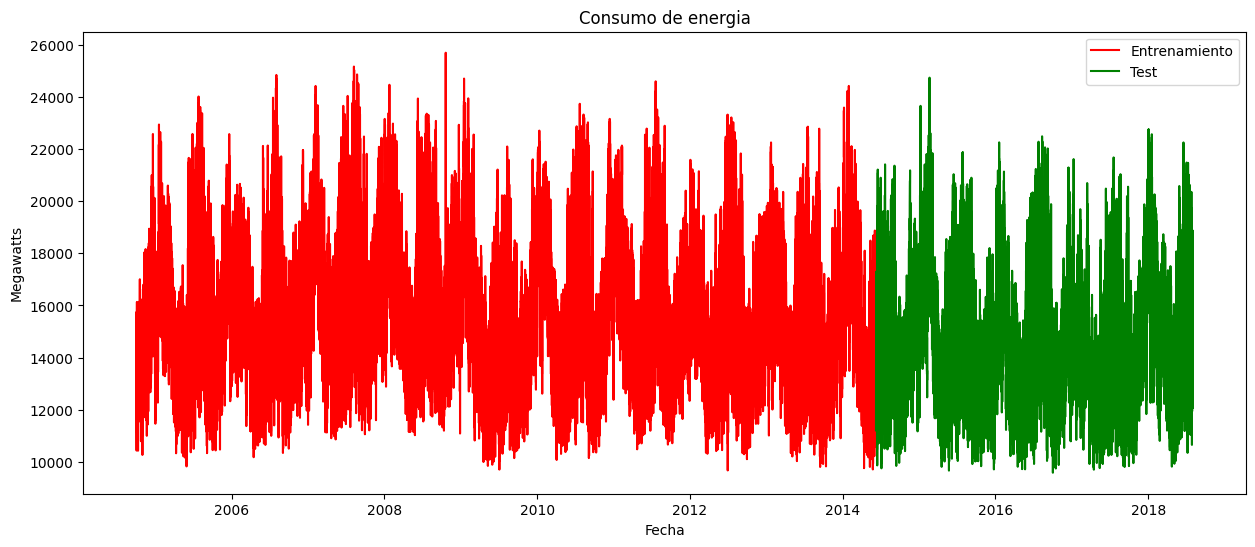

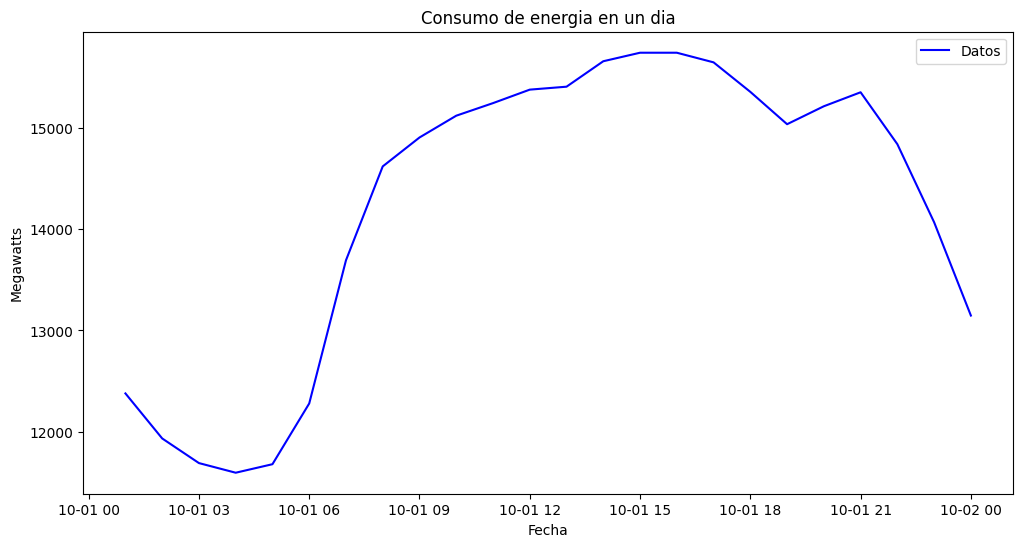

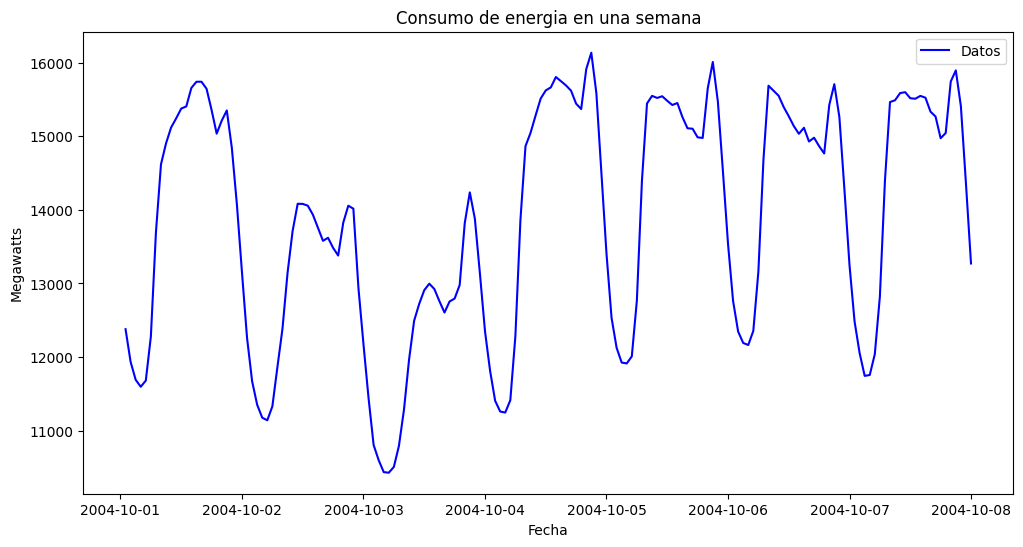

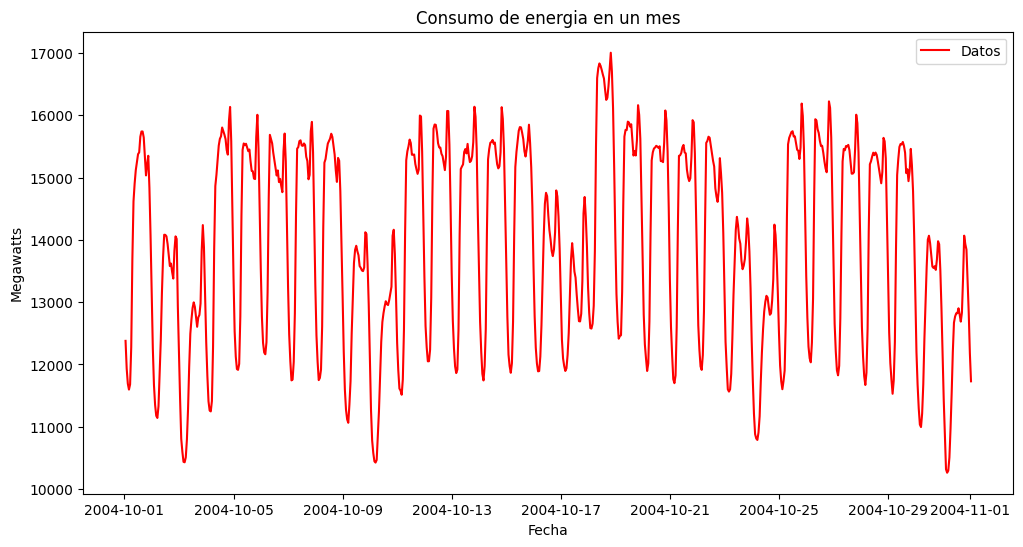

DEBUG:cmdstanpy:input tempfile: /tmp/tmpw7qumxm0/f0vr38a4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw7qumxm0/6d711tbb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96938', 'data', 'file=/tmp/tmpw7qumxm0/f0vr38a4.json', 'init=/tmp/tmpw7qumxm0/6d711tbb.json', 'output', 'file=/tmp/tmpw7qumxm0/prophet_modelkd_2jwc4/prophet_model-20240813045814.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:58:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:59:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


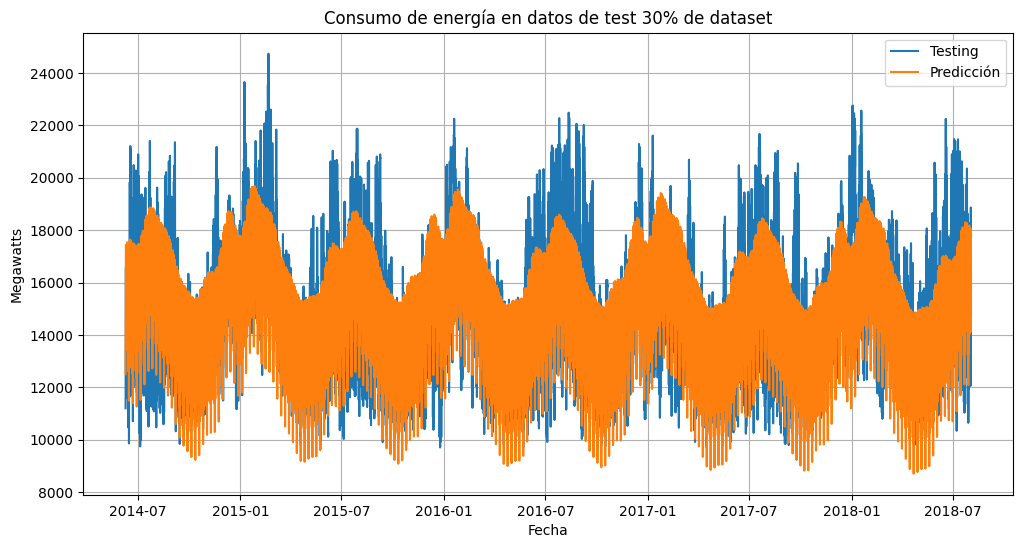

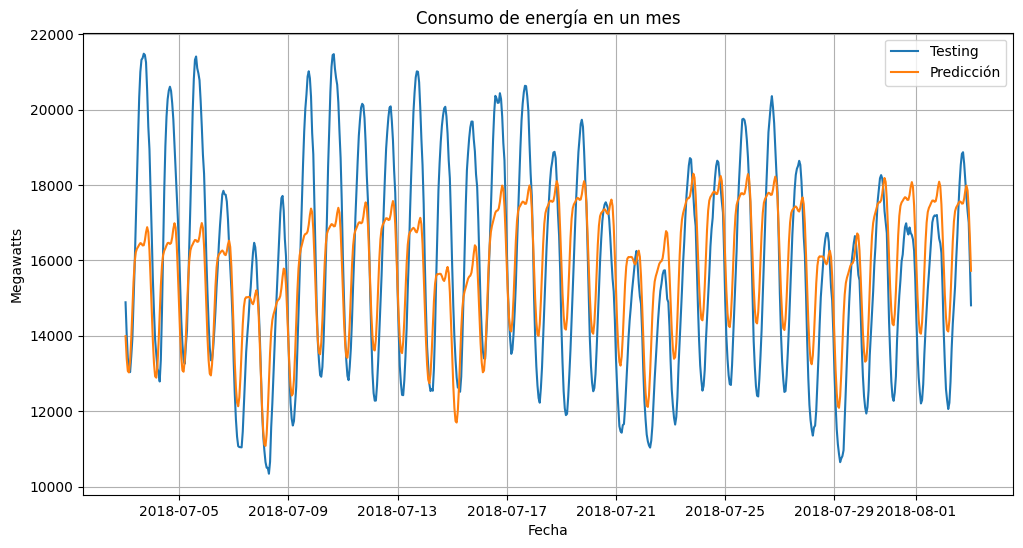

ARIMA RMSE: 1577.2566603274965, MAE: 1211.9163621779485, MAPE: 0.07792166367749023


In [5]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error


df = pd.read_csv("AEP_hourly.csv") # leemos los datos del archivo

# Limpiamos datos y ordenamos
df['Datetime'] = pd.to_datetime(df['Datetime']) # convertimos a tipo datetime
df = df.sort_values('Datetime')  # ordenamos
df = df.rename(columns={'Datetime': 'ds', 'AEP_MW': 'y'}) # renombramos
# Verificar filas con datos vacíos
datos_faltantes = df[df.isnull()].count().sum()
# Mostrar las filas con datos vacíos
print(f'Numero de filas vacias: {datos_faltantes}')

display(df.head())
display(df.tail())
df.describe()


# Dividimos datos de train y test
train, test = train_test_split(df, test_size=0.3, shuffle=False)
print("Datos para entrenar")
display(train.head())
print("Datos para hacer tests")
display(test.head())


# graficamos todos los datos para test y para train
plt.figure(figsize=(15, 6))
sns.lineplot(x=train['ds'], y=train["y"], label='Entrenamiento', color='red')
sns.lineplot(x=test['ds'], y=test["y"], label='Test', color='green')
plt.title("Consumo de energia")
plt.xlabel("Fecha")
plt.ylabel("Megawatts")
plt.legend()
plt.show()
# graficamos los datos de 1 dia alrededor
df_filtrado_dia = df.iloc[:24]
plt.figure(figsize=(12, 6))
sns.lineplot(x=df_filtrado_dia['ds'], y=df_filtrado_dia["y"], label='Datos', color='blue')
plt.title("Consumo de energia en un dia")
plt.xlabel("Fecha")
plt.ylabel("Megawatts")
plt.legend()
plt.show()
# graficamos los datos de 1 semana alrededor
df_filtrado_dia = df.iloc[:168]
plt.figure(figsize=(12, 6))
sns.lineplot(x=df_filtrado_dia['ds'], y=df_filtrado_dia["y"], label='Datos', color='blue')
plt.title("Consumo de energia en una semana")
plt.xlabel("Fecha")
plt.ylabel("Megawatts")
plt.legend()
plt.show()
# graficamos los datos de un mes alrededor
df_filtrado_mes = df.iloc[:744]
plt.figure(figsize=(12, 6))
sns.lineplot(x=df_filtrado_mes['ds'], y=df_filtrado_mes["y"], label='Datos', color='red')
plt.title("Consumo de energia en un mes")
plt.xlabel("Fecha")
plt.ylabel("Megawatts")
plt.legend()
plt.show()


# Creación y Entrenamiento del modelo
model = Prophet()
model.fit(train)


# Predecimos
future = model.make_future_dataframe(periods=len(test), freq='H') # creacion de un DataFrame para las fechas futuras (a predecir)
forecast = model.predict(future)  # Hacer predicciones - contiene fecha, prediccion, valor min de pred, valor mayor de pred
forecast_filtered = forecast[forecast['ds'] >= test['ds'].iloc[0]]  # filtrado para solo obtener predicciones para los datos de test


# Graficamos los resultados
plt.figure(figsize=(12, 6))
# plt.plot(train['ds'], train['y'], label='Entrenamiento')
plt.plot(test['ds'], test['y'], label='Testing')
plt.plot(forecast_filtered['ds'], forecast_filtered['yhat'], label='Predicción')
plt.legend()
plt.xlabel('Fecha')
plt.ylabel('Megawatts')
plt.title('Consumo de energía en datos de test 30% de dataset')
plt.grid(True)
plt.show()

# Graficar los resultados de mas cerca
plt.figure(figsize=(12, 6))
plt.plot(test['ds'].tail(744), test['y'].tail(744), label='Testing')
plt.plot(forecast_filtered['ds'].tail(744), forecast_filtered['yhat'].tail(744), label='Predicción')
plt.legend()
plt.xlabel('Fecha')
plt.ylabel('Megawatts')
plt.title('Consumo de energía en un mes')
plt.grid(True)
plt.show()


# Calculamos el error del modelo
rmse_prophet = mean_squared_error(df['y'], forecast['yhat'], squared=False)  # RMSE
mae_prophet = mean_absolute_error(df['y'], forecast['yhat'])  # MAE
mape_prophet = mean_absolute_percentage_error(df['y'], forecast['yhat'])  # MAPE
print(f"PROPHET RMSE: {rmse_prophet}, MAE: {mae_prophet}, MAPE: {mape_prophet}")
